# Classification of Pet's Faces

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).



# **IMPORTANT MESSAGE FROM KALEB** 
When this file is used it will grow to a file size that github cannot support for free
### To fix this issue:
Go to `Edit`
Select: `Clear Outputs of All Cells`


### Getting the Data

In this assignment, we will focus on relatively simple classification task - classification of pet's faces. This dataset consists of cut-out faces from [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Let's start by loading and visualizing the dataset.

In [1]:
# !wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
# !tar xfz petfaces.tar.gz
# !rm petfaces.tar.gz

We will define generic function to display a series of images from a list:

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

Now let's traverse all class subdirectories and plot first few images of each class:

In [3]:
# for cls in os.listdir('petfaces'):
#     print(cls)
#     display_images([Image.open(os.path.join('petfaces',cls,x)) 
#                     for x in os.listdir(os.path.join('petfaces',cls))[:10]])

Let's also define the number of classes in our dataset:

In [4]:
num_classes = len(os.listdir('petfaces'))
num_classes

37

## Preparing dataset for Deep Learning

To start training our neural network, we need to convert all images to tensors, and also create tensors corresponding to labels (class numbers). Most neural network frameworks contain simple tools for dealing with images:
* In Tensorflow, use `tf.keras.preprocessing.image_dataset_from_directory`
* In PyTorch, use `torchvision.datasets.ImageFolder`

As you have seen from the pictures above, all of them are close to square image ratio, so we need to resize all images to square size. Also, we can organize images in minibatches.

In [5]:
# CODE TO LOAD DATASET
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(256),         
    transforms.CenterCrop(256),     
    transforms.ToTensor(),          
])

dataset = datasets.ImageFolder('petfaces', transform = transform)
print(len(dataset))

7390


Now we need to separate dataset into train and test portions:

In [6]:
# CODE TO DO TRAIN/TEST SPLIT
from torch.utils.data import random_split

# Calculate the lengths of splits
total_len = len(dataset)
train_len = int(total_len * 0.67)
test_len = total_len - train_len

# Create the random splits
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print(len(train_dataloader))
print(len(test_dataloader))

155
77


Now let's print the size of tensors in our dataset. If you have done everything correctly, the size of training elements should be
 * `batch_size,3,image_size,image_size` for PyTorch
 * `batch_size` for Labels
 
 Labels should contain numbers of classes.

In [7]:
# Print tensor sizes
print(train_dataloader)

In [9]:
# Display the data
# Print the size of the tensors in the training set
for images, labels in train_dataloader:
    print('Images tensor shape:', images.shape)
    print('Labels tensor shape:', labels.shape)
    break  # We break after the first batch

# Print the size of the tensors in the testing set
for images, labels in test_dataloader:
    print('Images tensor shape:', images.shape)
    print('Labels tensor shape:', labels.shape)
    break  # We break after the first batch

Images tensor shape: torch.Size([32, 3, 256, 256])
Labels tensor shape: torch.Size([32])
Images tensor shape: torch.Size([32, 3, 256, 256])
Labels tensor shape: torch.Size([32])


## Define a neural network

For image classification, you should probably define a convolutional neural network with several layers. What to keep an eye for:
* Keep in mind the pyramid architecture, i.e. number of filters should increase as you go deeper
* Do not forget activation functions between layers (ReLU) and Max Pooling
* Final classifier can be with or without hidden layers, but the number of output neurons should be equal to number of classes.

An important thing is to get the activation function on the last layer + loss function right:
* In Tensorflow, you can use `softmax` as the activation, and `sparse_categorical_crossentropy` as loss. The difference between sparse categorical cross-entropy and non-sparse one is that the former expects output as the number of class, and not as one-hot vector.
* In PyTorch, you can have the final layer without activation function, and use `CrossEntropyLoss` loss function. This function applies softmax automatically. 

In [34]:
# CODE TO DEFINE NEURAL NETWORK
import torch.nn as nn

class KeiNet(nn.Module):
    def __init__(self):
        super(KeiNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=3,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(571536,37)

    def forward(self, x):
        # [3, 256, 256]
        x = nn.functional.relu(self.conv(x))
        # [9, 252, 252]
        x = self.flatten(x)
        # [571, 536]
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        # [37]
        return x
test_net = KeiNet().to(device)
summary(test_net,input_size=(32,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
KeiNet                                   [32, 37]                  --
├─Conv2d: 1-1                            [32, 9, 252, 252]         684
├─Flatten: 1-2                           [32, 571536]              --
├─Linear: 1-3                            [32, 37]                  21,146,869
Total params: 21,147,553
Trainable params: 21,147,553
Non-trainable params: 0
Total mult-adds (G): 2.07
Input size (MB): 25.17
Forward/backward pass size (MB): 146.32
Params size (MB): 84.59
Estimated Total Size (MB): 256.08

## Train the Neural Network

Now we are ready to train the neural network. During training, please collect accuracy on train and test data on each epoch, and then plot the accuracy to see if there is overfitting.

> To speed up training, you need to use GPU if available. While TensorFlow/Keras will automatically use GPU, in PyTorch you need to move both the model and data to GPU during training using `.to()` method in order to take advantage of GPU acceleration. 


In [35]:
import torch
torch.__version__
# Kaleb code
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(torch.cuda.get_device_name(0))

Using cuda device
NVIDIA GeForce GTX 1080


In [46]:
# TRAIN THE NETWORK
from torchinfo import summary

def train(net, dataloader_train, dataloader_test, epochs = 5, lr = 0.001):
    train_loss, train_acc = [],[]
    test_loss, test_acc = [],[]

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for ep in range(epochs):
        train_loss_list, test_loss_list = [], []
        sum_train_acc, sum_test_acc = [],[]
        net.train()
        for X, y in dataloader_train:
            X, y = X.to(device), y.to(device)

            # Make predictions and loss calculations
            pred = net(X)
            loss = loss_fn(pred, y)
            train_loss_list.append(loss.item())

            # Back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch accuracy calculations
            class_pred = torch.argmax(pred, axis=1)
            correct = (class_pred == y).sum()
            curr_acc = correct / len(y)
            sum_train_acc.append(curr_acc)

        train_loss.append(loss.item())
        train_acc.append((sum(sum_train_acc) / len(sum_train_acc)).cpu().detach().numpy())
        print(f"Epoch {ep} TRAIN last loss: {loss.item()}, average accuracy: {sum(sum_train_acc) / len(sum_train_acc)}")
        
        
        net.eval()
        for X, y in dataloader_test:
            X, y = X.to(device), y.to(device)

            # Make predictions and loss calculations
            pred = net(X)
            loss = loss_fn(pred, y)

             # Batch accuracy calculations
            class_pred = torch.argmax(pred, axis=1)
            correct = (class_pred == y).sum()
            curr_acc = correct / len(y)
            sum_test_acc.append(curr_acc)

        test_loss.append(loss.item())
        test_acc.append((sum(sum_test_acc) / len(sum_test_acc)).cpu().detach().numpy())
        print(f"Epoch {ep} TEST last loss: {loss.item()}, average accuracy: {sum(sum_test_acc) / len(sum_test_acc)}")
        
            
    
    return train_loss, train_acc, test_loss, test_acc

net = KeiNet().to(device)
train_loss_list, train_acc_list, test_loss_list, test_acc_list = train(net, train_dataloader, test_dataloader)

Epoch 0 TRAIN last loss: 3.52070689201355, average accuracy: 0.05935308337211609
Epoch 0 TEST last loss: 3.47412109375, average accuracy: 0.0643552839756012
Epoch 1 TRAIN last loss: 1.654506802558899, average accuracy: 0.5317496657371521
Epoch 1 TEST last loss: 4.093550682067871, average accuracy: 0.08198051899671555
Epoch 2 TRAIN last loss: 0.28542691469192505, average accuracy: 0.9333099126815796
Epoch 2 TEST last loss: 4.029034614562988, average accuracy: 0.08893784880638123
Epoch 3 TRAIN last loss: 0.0686221718788147, average accuracy: 0.9965725541114807
Epoch 3 TEST last loss: 7.814624309539795, average accuracy: 0.08180658519268036
Epoch 4 TRAIN last loss: 0.00023041540407575667, average accuracy: 1.0
Epoch 4 TEST last loss: 7.812180519104004, average accuracy: 0.08887986838817596


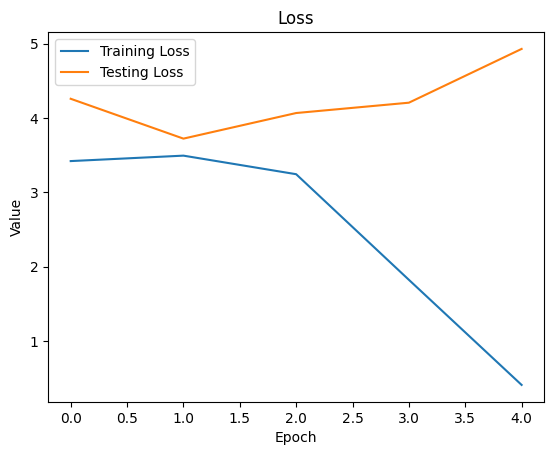

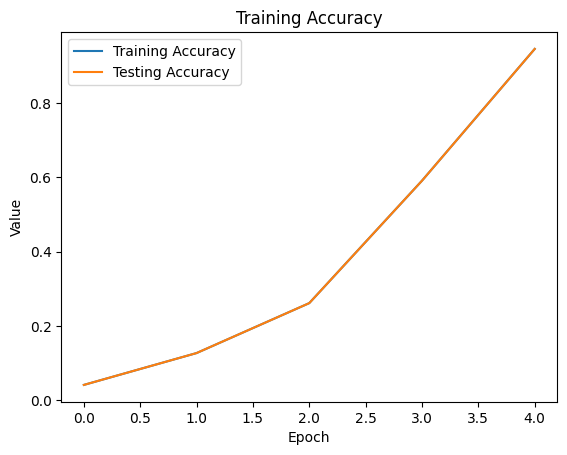

In [45]:
# PLOT THE ACCURACY on train and validation dataset
def graph_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list):
    epochs = range(len(train_loss_list))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, test_loss_list, label='Testing Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Loss')
    plt.show()
    plt.plot(epochs, train_acc_list, label='Training Accuracy')
    plt.plot(epochs, test_acc_list, label='Testing Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Percent')
    plt.title('Training Accuracy')
    plt.show()

# for i in range(len(train_acc_list)):
#     train_acc_list[i] = train_acc_list[i].cpu().detach().numpy()
#     test_acc_list[i] = test_acc_list[i].cpu().detach().numpy()
    
graph_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

What can you say about overfitting? What can be done to improve the accuracy of the model

## Optional: Calculate Top3 Accuracy

In this exercise, we were dealing with classification with quite high number of classes (35), so our result - around 50% validation accuracy - is pretty good. Standard ImageNet dataset has even more - 1000 classes.

In such cases it is difficult to ensure that model **always** correctly predicts the class. There are cases when two breeds are very similar to each other, and the model returns very similar probablities (eg., 0.45 and 0.43). If we measure standard accuracy, it will be considered a wrong case, even though the model did very small mistake. This, we often measure another metric - an accuracy within top 3 most probable predictions of the model.

We consider the case accurate if target label is contained within top 3 model predictions. 

To compute top-3 accuracy on the test dataset, you need to manually go over the dataset, apply the neural network to get the prediction, and then do the calculations. Some hints:

* In Tensorflow, use `tf.nn.in_top_k` function to see if the `predictions` (output of the model) are in top-k (pass `k=3` as parameter), with respect to `targets`. This function returns a tensor of boolean values, which can be converted to `int` using `tf.cast`, and then accumulated using `tf.reduce_sum`.
* In PyTorch, you can use `torch.topk` function to get indices of classes with highers probabilities, and then see if the correct class belongs to them. See [this](https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b) for more hints.


In [ ]:
# CALCULATE TOP-3 ACCURACY

## Optional: Build Cats vs. Dogs classification

We also want to see how accurate our binary cats vs. dogs classification would be on the same dateset. To do it, we need to adjust labels:

In [ ]:
# Define dataset that contains only two labels: 0 = cat, 1 = dog
# Hint: use class name prefix to figure out which one is which

In [ ]:
# Define neural network architecture and train